<a href="https://colab.research.google.com/github/HenryJi529/ColabNotebooks/blob/main/LecturePytorch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics
!pip install -U mlxtend

from IPython.display import clear_output
clear_output()

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import torchmetrics
from torchmetrics import ConfusionMatrix

import mlxtend
from mlxtend.plotting import plot_confusion_matrix

import random
import numpy as np
import matplotlib.pyplot as plt 

import requests
from pathlib import Path 
import time
import datetime
from tqdm.auto import tqdm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def better_print(var):
    formatted_output = colorama.Fore.YELLOW + colorama.Style.BRIGHT + str(var) + colorama.Style.RESET_ALL
    return formatted_output

## Getting Dataset

In [ ]:
train_data = torchvision.datasets.FashionMNIST(
  root="data",
  train=True,
  download=True,
  transform=torchvision.transforms.ToTensor(),
  target_transform=None
)

test_data = torchvision.datasets.FashionMNIST(
  root="data",
  train=False,
  download=True,
  transform=torchvision.transforms.ToTensor(),
  target_transform=None
)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
image1 = train_data[0]
image1[0].shape

torch.Size([1, 28, 28])

In [ ]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

## Visualize Data

torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

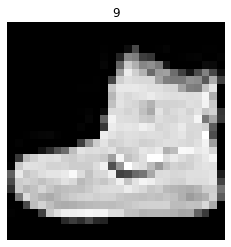

In [ ]:
image, label = train_data[0]
print(image.shape)
plt.imshow(image.squeeze(), cmap='gray')
plt.title(label)
plt.axis(False)

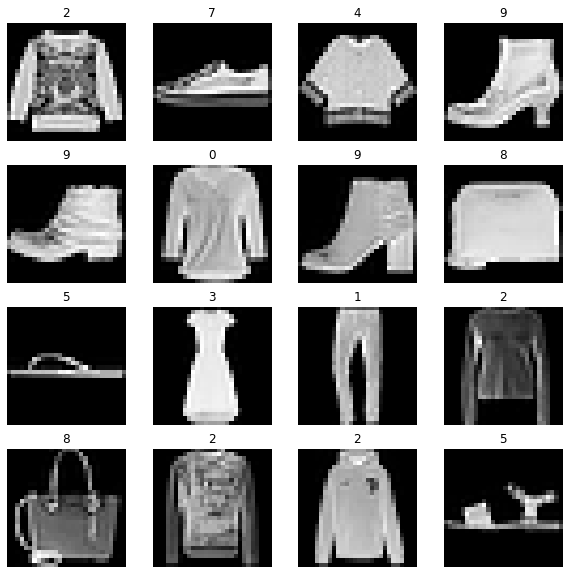

In [ ]:
torch.manual_seed(43)
rows, cols = 4,4
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i in range(rows*cols):
  random_idx = torch.randint(0, len(train_data), size=(1,)).item()
  image, label = train_data[random_idx]
  axes[int(i / cols)][i % cols].imshow(image.squeeze(), cmap='gray')
  axes[int(i / cols)][i % cols].set_title(label)
  # axes[int(i / cols)][i % cols].yaxis.set_visible(False)
  axes[int(i / cols)][i % cols].axis(False)

## Prepare DataLoader

In [ ]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [ ]:
train_dataloader.batch_size

32

In [ ]:
train_dataloader.__len__()

1875

In [ ]:
train_dataloader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 1, label size: torch.Size([])


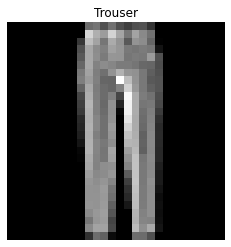

In [ ]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## Build Model

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)

In [ ]:
output.shape

torch.Size([1, 784])

In [ ]:
# class FashionMNISTModel(nn.Module):
#   def __init__(self, input_features, output_features, hidden_units):
#     super().__init__()
#     self.layer_stack = nn.Sequential(
#         torch.nn.Flatten(),
#         torch.nn.Linear(input_features, hidden_units),
#         torch.nn.ReLU(),
#         torch.nn.Linear(hidden_units, hidden_units),
#         torch.nn.ReLU(),
#         torch.nn.Linear(hidden_units, output_features),
#     )
#   def forward(self, x:torch.Tensor) -> torch.Tensor:
#     return self.layer_stack(x)

# model = FashionMNISTModel(train_features_batch.shape[1]*train_features_batch.shape[2]*train_features_batch.shape[3], len(class_names), 20).to(DEVICE)

input_channels = train_features_batch.shape[1]
rows = train_features_batch.shape[2]
cols = train_features_batch.shape[3]

class FashionMNISTModel(nn.Module):
  def __init__(self, input_shape, output_shape, hidden_units):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*int(rows*cols/4/4),
                  out_features=output_shape)
    )
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    Z1 = self.conv_block_1(x)
    Z2 = self.conv_block_2(Z1)
    Z3 = self.classifier(Z2)
    return Z3

model = FashionMNISTModel(input_channels, len(class_names), 10).to(DEVICE)

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=len(train_dataloader.dataset.classes)).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

## Create Training Loop

**分批训练**

```python
for batch, (X,y) in tqdm(enumerate(data_loader)):
  if batch % 200 == 0:
    print(f"Looked at {batch * (len(X))}/{len(train_dataloader.dataset)} samples.") 
```

In [ ]:
from typing import Dict, List
# metric_fns: Dict[str, torchmetrics.metric.Metric]

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               metric_fn: torchmetrics.metric.Metric):
  
  print("Starting Training...")

  train_loss, train_metric = 0, 0

  model.train()

  for batch in tqdm(data_loader):
    X, y = batch
    X, y = X.to(DEVICE), y.to(DEVICE)

    y_logits = model(X)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y)
    metric = metric_fn(y_pred, y)
  
    train_loss += loss
    train_metric += metric

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_metric /= len(data_loader)

  return train_loss.item(), train_metric.item()

In [ ]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               metric_fn: torchmetrics.metric.Metric):

  print("Starting Evaluating...")

  test_loss, test_metric = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(DEVICE), y.to(DEVICE)

      y_logits = model(X)
      y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

      test_loss += loss_fn(y_logits, y)
      test_metric += metric_fn(y_pred, y)

    test_loss /= len(test_dataloader)
    test_metric /= len(test_dataloader)

  return test_loss.item(), test_metric.item()

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = time.time()
train_losses = []
test_losses = []
train_accs = []
test_accs = []

epochs = 10

for epoch in tqdm(range(epochs)):

  print(f"Epoch {epoch}:")

  train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn)
  test_loss, test_acc = test_step(model, test_dataloader, loss_fn, accuracy_fn)

  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_accs.append(train_acc)
  test_accs.append(test_acc)

  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")
  print("--------"*10)

end_time = time.time()
during_time = int(end_time - start_time)

print(f"运行时间: {datetime.timedelta(seconds=during_time)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4492 | Test Loss: 0.3953 | Train Acc: 83.67% | Test Acc: 85.73%
--------------------------------------------------------------------------------
Epoch 1:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3635 | Test Loss: 0.3820 | Train Acc: 86.67% | Test Acc: 85.74%
--------------------------------------------------------------------------------
Epoch 2:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3504 | Test Loss: 0.4478 | Train Acc: 87.08% | Test Acc: 83.42%
--------------------------------------------------------------------------------
Epoch 3:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3479 | Test Loss: 0.3682 | Train Acc: 87.17% | Test Acc: 86.67%
--------------------------------------------------------------------------------
Epoch 4:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3357 | Test Loss: 0.3623 | Train Acc: 87.68% | Test Acc: 86.33%
--------------------------------------------------------------------------------
Epoch 5:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3315 | Test Loss: 0.3655 | Train Acc: 87.75% | Test Acc: 86.30%
--------------------------------------------------------------------------------
Epoch 6:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3342 | Test Loss: 0.3458 | Train Acc: 87.81% | Test Acc: 87.39%
--------------------------------------------------------------------------------
Epoch 7:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3330 | Test Loss: 0.3546 | Train Acc: 87.59% | Test Acc: 87.38%
--------------------------------------------------------------------------------
Epoch 8:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3320 | Test Loss: 0.3790 | Train Acc: 87.80% | Test Acc: 86.21%
--------------------------------------------------------------------------------
Epoch 9:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3323 | Test Loss: 0.3622 | Train Acc: 87.77% | Test Acc: 87.26%
--------------------------------------------------------------------------------
运行时间: 0:02:59


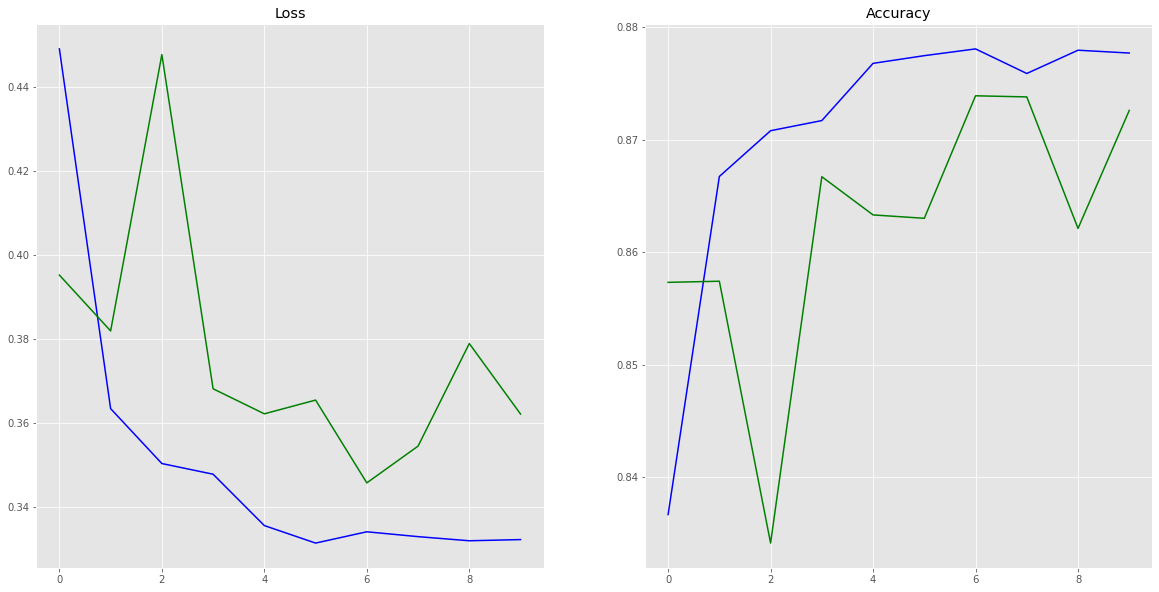

In [ ]:
with plt.style.context('ggplot'):
  fig, axes = plt.subplots(1,2, figsize=(20,10))
  axes[0].plot(train_losses, c='b')
  axes[0].plot(test_losses, c='g')
  axes[0].set_title('Loss')
  axes[1].plot(train_accs, c='b')
  axes[1].plot(test_accs, c='g')
  axes[1].set_title('Accuracy')

## Evaluate Model

In [ ]:
def eval_mode(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
  loss, acc = 0,0
  y_preds = []
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(DEVICE), y.to(DEVICE)

      y_logits = model(X)
      y_pred_prob = torch.softmax(y_logits, dim=1)
      y_pred = y_pred_prob.argmax(dim=1)

      loss += loss_fn(y_logits, y)
      acc += accuracy_fn(y_pred, y)
      y_preds.append(y_pred)
    
    acc /= len(data_loader)
    loss /= len(data_loader)

  return {
      "model_name": model.__class__.__name__,
      "model_loss": loss.item(),
      "model_acc": acc.item(),
      "model_pred": y_preds
  }

model_result = eval_mode(model, test_dataloader, loss_fn, accuracy_fn)
print(f"test_loss: {model_result['model_loss']:.4f} | test_acc: {model_result['model_acc']*100:.2f}")

  0%|          | 0/313 [00:00<?, ?it/s]

test_loss: 0.3622 | test_acc: 87.26


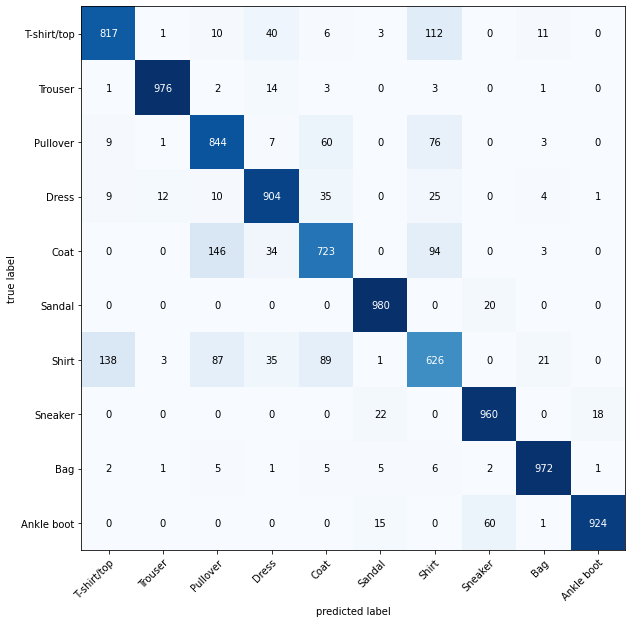

In [ ]:
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass").to(DEVICE)
confmat_tensor = confmat(preds=torch.cat(model_result["model_pred"]), target=test_data.targets.to(DEVICE))
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(),
    class_names=class_names,
    figsize=(10,10)
)

## Make Predictions

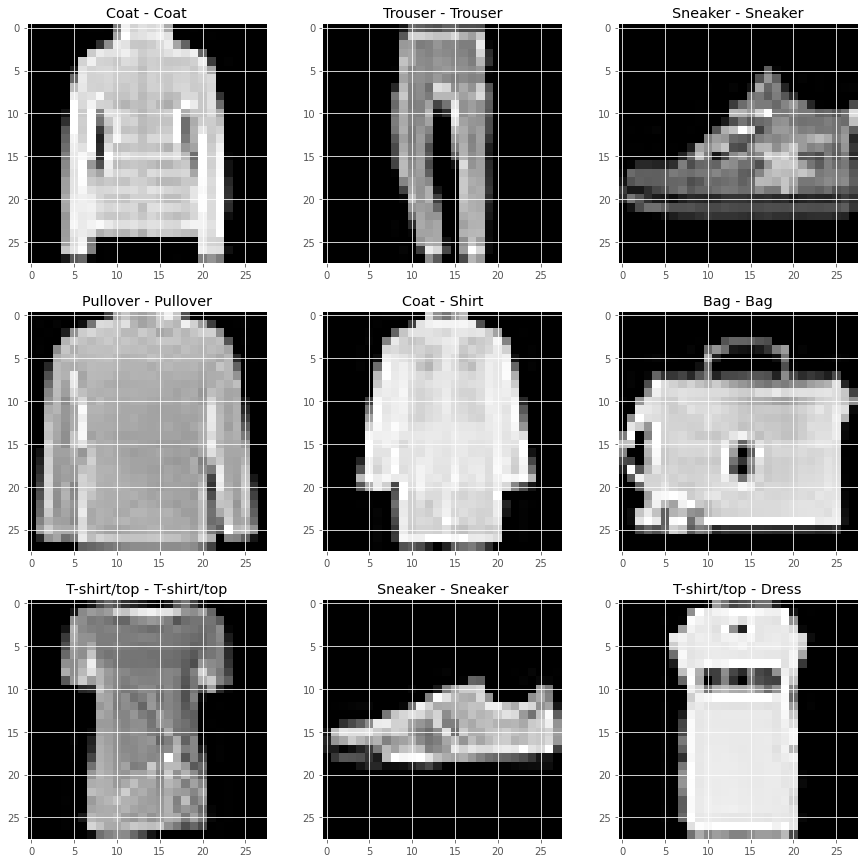

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list):
  pred_labels = []
  model.eval()
  with torch.inference_mode():
    for X in data:
      X = X.unsqueeze(0).to(DEVICE)
      y_logits = model(X)
      y_pred_prob = torch.softmax(y_logits, dim=1)
      y_pred_label = y_pred_prob.argmax(dim=1)
      pred_labels.append(y_pred_label.item())
  return pred_labels

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

pred_labels = make_predictions(model, test_samples)

with plt.style.context('ggplot'):
  fig, axes = plt.subplots(3,3, figsize=(15,15))
  for ind, (sample, true_label, pred_label) in enumerate(zip(test_samples, test_labels, pred_labels)):
    ax = axes[int(ind/3)][ind%3]
    ax.imshow(sample.squeeze(), cmap='gray')
    ax.set_title(f"{class_names[true_label]} - {class_names[pred_label]}")

## Save Model

In [ ]:
from pathlib import Path
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(parents=True, exist_ok=True) 
MODEL_SAVE_PATH = MODEL_DIR / Path("model.pth")
print(f"save model to {MODEL_SAVE_PATH}")
torch.save(model.state_dict(), f=MODEL_SAVE_PATH)

save model to models/model.pth


In [ ]:
model_loaded = FashionMNISTModel(input_channels, len(class_names), 10).to(DEVICE)
model_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))
model_loaded_result = eval_mode(model_loaded, test_dataloader, loss_fn, accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
np.isclose(model_loaded_result['model_loss'], model_result['model_loss'])

True